# Experiments

What kind of question would we like to answer ... 

 Overall, these experiments will help use to estimate by how much the use of the upper bound in computing the age latency can be beneficial. 
 
 there are two case to consider, optimum and eapproximate. 
 First the optimum case, by how much using the lower can accelerate the search (in term of iterations, or more generally in term of execution time). 
 Secondly by introducing the lower bound to our mechanism, we also enable approximate solution with garanties in delta. By considering several situations of acceptable errors (such as 1%, 5%, 10%, 15%), by how much the computation of age latency can be improved. 
 

## Generate sample data files and loading them... 

In [167]:
EXEC_PATH="../cmake-build-release/src/"
BENCHMARK = EXEC_PATH + "/benchmarkAgelatency"
ANALYSE = EXEC_PATH + "/lig-analyse"
ALL_KIND=["automotive", "generic", "harmonic"]

In [2]:
!mkdir -p data
!if [ ! -e data/automotive.csv ]; then echo Not found; fi

In [3]:
%%script env BENCHMARK="$BENCHMARK" bash

for kind in automotive harmonic generic; do 
    if [ ! -e data/$kind.csv ]; then 
        $BENCHMARK  -kind $kind -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -detailed -logfile data/"$kind".csv; 
    fi

    if [ ! -e data/"$kind"diti.csv ]; then  
        $BENCHMARK  -kind $kind -begin_n 10 -end_n 30  -step_n 10 -sample_count 5 -iter_count 1 -DiEqualTi -detailed -logfile data/"$kind"diti.csv; 
    fi
done

In [4]:
%%script env BENCHMARK="$BENCHMARK" bash

if [ ! -e data/containsAnomalies.csv ]; then $BENCHMARK -begin_n 4 -end_n 5 -kind generic -step_n 1 -detailed -iter_count 1 -sample_count 10000 -logfile data/containsAnomalies.csv; fi
if [ ! -e data/containsAnomalies_diti.csv ]; then $BENCHMARK -begin_n 4 -end_n 5 -kind generic -step_n 1 -detailed -iter_count 1 -sample_count 10000 -logfile data/containsAnomalies_diti.csv -DiEqualTi; fi
if [ ! -e data/seek3.csv ]; then $BENCHMARK -begin_n 3 -end_n 5 -kind generic -step_n 1 -detailed -iter_count 1 -sample_count 10000 -logfile data/seek3.csv; fi

# Tools to load the files

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def openLog(filename, with_gain=[]):
    toIntList = lambda x: [int(y) for y in x.strip("[]").split(",")] if x != "[]" else []
    toFloatList = lambda x: [float(y) for y in x.strip("[]").split(",")] if x != "[]" else []
    df = pd.read_csv(filename, sep=";",
                     converters={
                         "ExpansionVertex": toIntList,
                         "ExpansionEdges": toIntList,
                         "LowerBounds": toIntList,
                         "UpperBounds": toIntList,
                         "gen_time": toFloatList,
                         "lbp_time": toFloatList,
                         "ubp_time": toFloatList,
                     }
                    )
    
    # Check data is as expected
    assert("seed" in df.columns)

    # Remove zero-task cases, annoying and useless.
    df = df[df["n"] > 0]
    
    # Add extra data about filename
    df["filename"] = filename
    
    # Pick up the edge dentisty 
    df["edge_density"] = df["m"] / (df["n"]  * (df["n"] - 1))
    df["edge_density"] = df["edge_density"].apply(lambda x : "1.High" if x > 0.3 else "2.Medium" if x > 0.2 else "3.Low")
    
    
    # Rename kinds
    kind_name = {1:"generic", 2:"harmonic", 3:"automotive"}
    df["kind"] = df["kind"].apply(lambda x : kind_name[x])
    
    # Normalize listes 
    df.LowerBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.LowerBounds]  , axis = 1)
    df.UpperBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.UpperBounds]  , axis = 1)
    df.ExpansionVertex = df.apply(lambda x :  [y/(x.sum_n+2) for y in x.ExpansionVertex]  , axis = 1)

    
    ## Old test
    #assert(df.ExpansionVertex.apply(max).max())
    #assert(df.LowerBounds.apply(max).max())
    #assert(df.UpperBounds.apply(max).max())

    for label in ["gen_time", "lbp_time", "ubp_time"] :
        df[label+"_detail"] = df[label].copy()
        df[label] = df[label].apply(sum)
                        
                            
    df["BoundsDistances"] = df.apply(lambda x : [abs( l - r ) for (l,r) in zip(x.LowerBounds,x.UpperBounds)], axis=1)
    df["bounds_shift"] = df.apply ( lambda x : (x["LowerBounds"].index(1) - x["UpperBounds"].index(1)) if x["LowerBounds"].count(1) else None , axis=1)
    df["early_bounds"] = df.apply ( lambda x : ((x["LowerBounds"].index(1) + 1< len(x["LowerBounds"])) and  (x["UpperBounds"].index(1) + 1 < len(x["UpperBounds"]) ))  if x["LowerBounds"].count(1) else None , axis=1)
    df['remain_time'] = (df["total_time"] - df["gen_time"] - df["lbp_time"] - df["ubp_time"])
    

    if len(with_gain) > 0 :
        
        df["ori_time"] =  df["gen_time"] + df["ubp_time"]
        df["ori_space"] =  df.apply(lambda x : x.ExpansionVertex[x.IterationCount-1] , axis=1)

        for delta in with_gain :
            deltaStr  = str(delta)
            target = 1.0 - (delta/100.0)

            def when_to_finish (row) :
                result = len(row.UpperBounds) - 1
                for i in range(result):
                    if (min(row.UpperBounds[:i+1]) - max(row.LowerBounds[:i+1])) <= (delta/100.0):
                        return i
                return result
            df["NewIterationCount"+deltaStr] = df.apply(when_to_finish, axis = 1) + 1
            new_gen_time =  df.apply(lambda x: sum(x["gen_time_detail"][:x["NewIterationCount"+deltaStr]]), axis = 1)
            new_lbp_time =  df.apply(lambda x: sum(x["lbp_time_detail"][:x["NewIterationCount"+deltaStr]]), axis = 1)
            new_ubp_time =  df.apply(lambda x: sum(x["ubp_time_detail"][:x["NewIterationCount"+deltaStr]]), axis = 1)

            new_time =   new_gen_time + new_lbp_time + new_ubp_time
            
            gain =  (df["ori_time"] - new_time) / df["ori_time"]
            df["time_gain"+deltaStr] = gain.fillna(0.0)
            new_space = df.apply(lambda x : x.ExpansionVertex[x["NewIterationCount"+deltaStr]-1] , axis=1)
            gain =  (df["ori_space"] - new_space) / df["ori_space"]
            df["space_gain"+deltaStr] = gain.fillna(0.0)

        for label in ["gen_time", "lbp_time", "ubp_time"] :
            df[label+"_new"] =  df.apply(lambda x: sum(x[label+"_detail"][:x["NewIterationCount0"]]), axis = 1)

    
    
    return df.reset_index()

df = openLog("data/automotive.csv")
df = openLog("data/automotive.csv",with_gain=range(0,10,2))

In [6]:
df.columns

Index(['index', 'seed', 'kind', 'DiEqTi', 'n', 'm', 'sum_n', 'AgeLatency',
       'IterationCount', 'ExpansionVertex', 'ExpansionEdges', 'LowerBounds',
       'UpperBounds', 'gen_time', 'lbp_time', 'ubp_time', 'total_time',
       'filename', 'edge_density', 'gen_time_detail', 'lbp_time_detail',
       'ubp_time_detail', 'BoundsDistances', 'bounds_shift', 'early_bounds',
       'remain_time', 'ori_time', 'ori_space', 'NewIterationCount0',
       'time_gain0', 'space_gain0', 'NewIterationCount2', 'time_gain2',
       'space_gain2', 'NewIterationCount4', 'time_gain4', 'space_gain4',
       'NewIterationCount6', 'time_gain6', 'space_gain6', 'NewIterationCount8',
       'time_gain8', 'space_gain8'],
      dtype='object')

In [7]:
def openLogs(filelist, **kwargs):
    df = None
    for f in filelist:
        df = pd.concat([df,openLog(f, **kwargs)], ignore_index=True)
    return df
df = openLogs(["data/automotive.csv", "data/harmonic.csv", "data/generic.csv"])

##  What is the maximum and minimum error we get from the first lower bound compared with the final latency ?

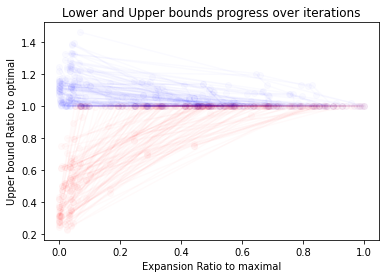

In [8]:
def lower_upper_detailled (df, alpha = None) :
    if not alpha :
        alpha = max ( 0.02,  1.0 / len(df) )
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.LowerBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "r", alpha = alpha)
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.UpperBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "b", alpha = alpha)
    _ = plt.xlabel("Expansion Ratio to maximal")
    _ = plt.ylabel("Upper bound Ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations")
lower_upper_detailled (df)

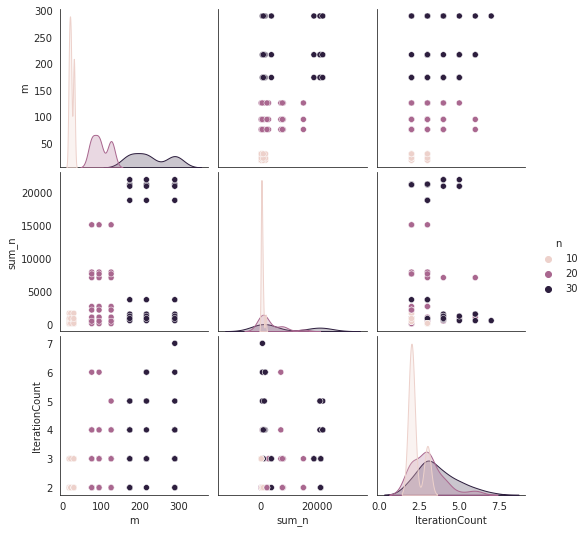

In [9]:
import seaborn as sns

def summarizePlots(df) :
    with sns.axes_style('white'):
        #_ = sns.jointplot("n", "m", data=df, kind='hex')
        _ = sns.pairplot(data=df[[ "n","m",  "sum_n", "IterationCount"]], hue="n")
summarizePlots(df)

## Study of the bounds

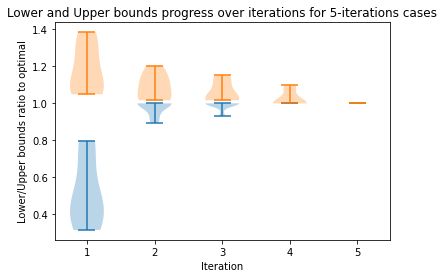

In [10]:
def plotBoundsByIteration(df, itercount) :
    sdf  =  df[df.IterationCount == itercount]
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(itercount)))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(itercount)))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    
plotBoundsByIteration(df, 5)
_ = plt.title("Lower and Upper bounds progress over iterations for 5-iterations cases")

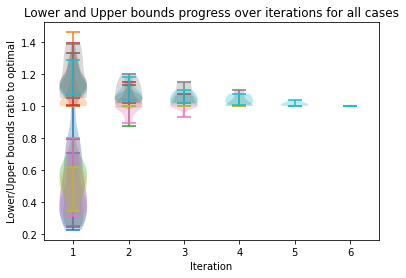

In [11]:
for it in range(1,df.IterationCount.max() + 1) :
    if len(df[df.IterationCount == it]) > 1:
        plotBoundsByIteration(df, it)
_ = plt.title("Lower and Upper bounds progress over iterations for all cases")

In [12]:
def plotBounds(df, title = None) :
    sdf = df.copy()
    sdf.LowerBounds = sdf.LowerBounds.apply(lambda x: [max(x[:i]+[x[i]]) for i in range(len(x))])
    sdf.LowerBounds = sdf.apply (lambda x : x.LowerBounds + (df.IterationCount.max() - x.IterationCount)*x.LowerBounds[-1:], axis = 1)
    sdf.UpperBounds = sdf.apply (lambda x : x.UpperBounds + (df.IterationCount.max() - x.IterationCount)*x.UpperBounds[-1:], axis = 1)
    plt.figure()
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    if title is None :
        _ = plt.title("Lower and Upper bounds progress over iterations for all cases")
    else :
        _ = plt.title(title)

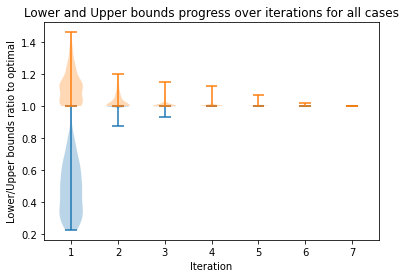

In [13]:
plotBounds(df) 

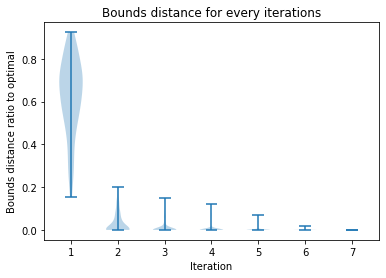

In [14]:
def plotBoundsDistances(df) :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.BoundsDistances.to_list(), columns=range(sdf.IterationCount.max())))
    _ = plt.title("Bounds distance for every iterations")
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Bounds distance ratio to optimal")
plotBoundsDistances(df)

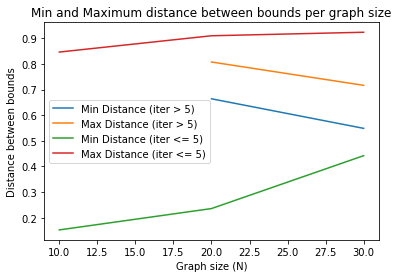

In [15]:
def plotMinMaxBoundDistance (df, label1 = "Minimal distance", label2 = "Maximal distance") :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    sdf["BoundsDistancesMax"] = sdf.BoundsDistances.apply(lambda x : max(x))

    x = sdf.groupby("n").max().reset_index()["n"]
    y1 = sdf.groupby("n").min().reset_index()["BoundsDistancesMax"]
    y2 = sdf.groupby("n").max().reset_index()["BoundsDistancesMax"]

    _ = plt.plot(x,y1,  label = label1)
    _ = plt.plot(x,y2,  label = label2)
    _ = plt.title("Min and Maximum distance between bounds per graph size")
    _ = plt.xlabel("Graph size (N)")
    _ = plt.ylabel("Distance between bounds")
    _ = plt.legend()
plotMinMaxBoundDistance(df[df.IterationCount > 5], label1="Min Distance (iter > 5)", label2="Max Distance (iter > 5)")
plotMinMaxBoundDistance(df[df.IterationCount <= 5], label1="Min Distance (iter <= 5)", label2="Max Distance (iter <= 5)")

In [16]:
import seaborn as sns
    
def plotDataFrame(_df, header="Untitled") :
    fig, axes = plt.subplots(3,2,figsize=(10,10))
    fig.suptitle(f'Summary from {header}')
    plt.sca(axes[0,0])
    plotBounds(_df)
    plt.sca(axes[1,0])
    plotBoundsDistances(_df)
    plt.sca(axes[0,1])
    lower_upper_detailled(_df)
    plt.sca(axes[1,1])
    plotMinMaxBoundDistance(_df)
    plt.sca(axes[2,0])
    df["bounds_shift"].hist()
    plt.tight_layout()
    summarizePlots(_df)
    _ = df[[ "n","m",  "sum_n", "IterationCount"]].hist()
    
def plotDataFile(filename) :
    _df = openLog(filename)
    plotDataFrame(_df, filename)
   

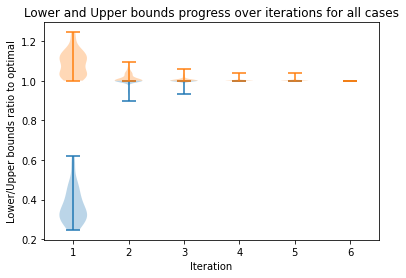

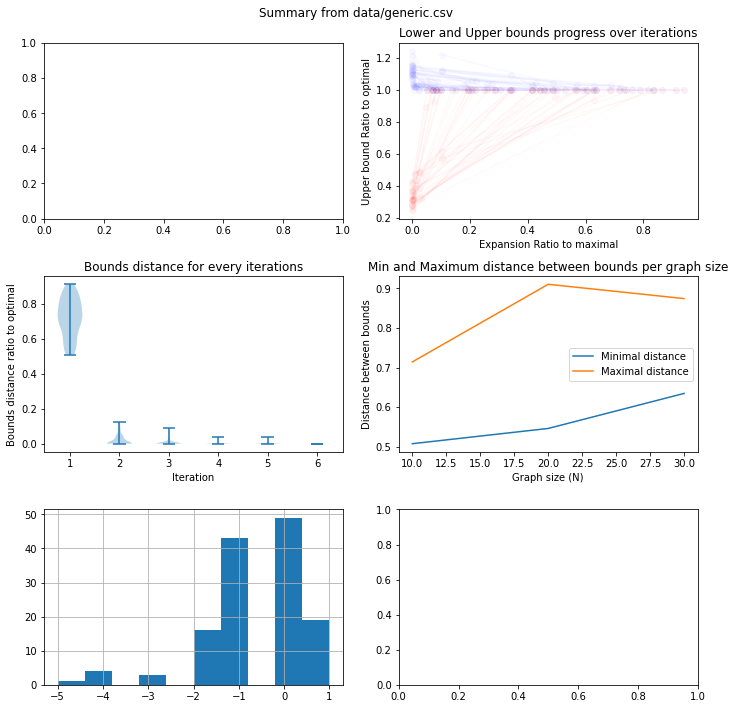

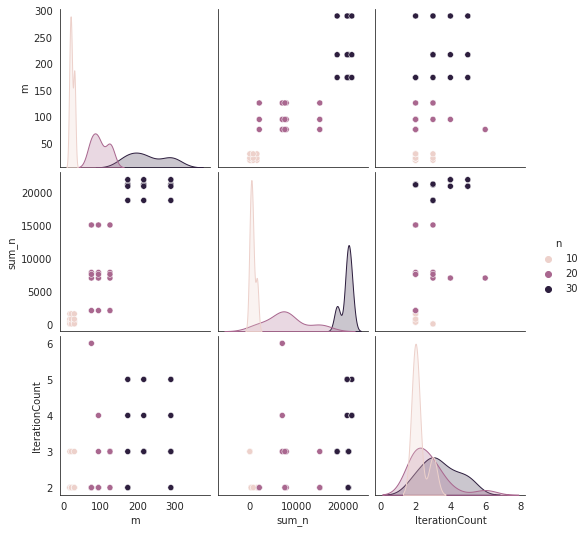

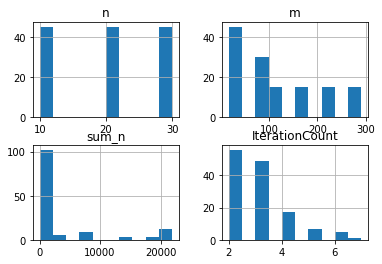

In [17]:
plotDataFile("data/generic.csv")

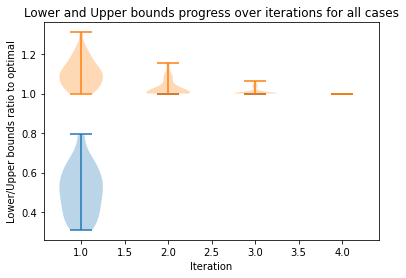

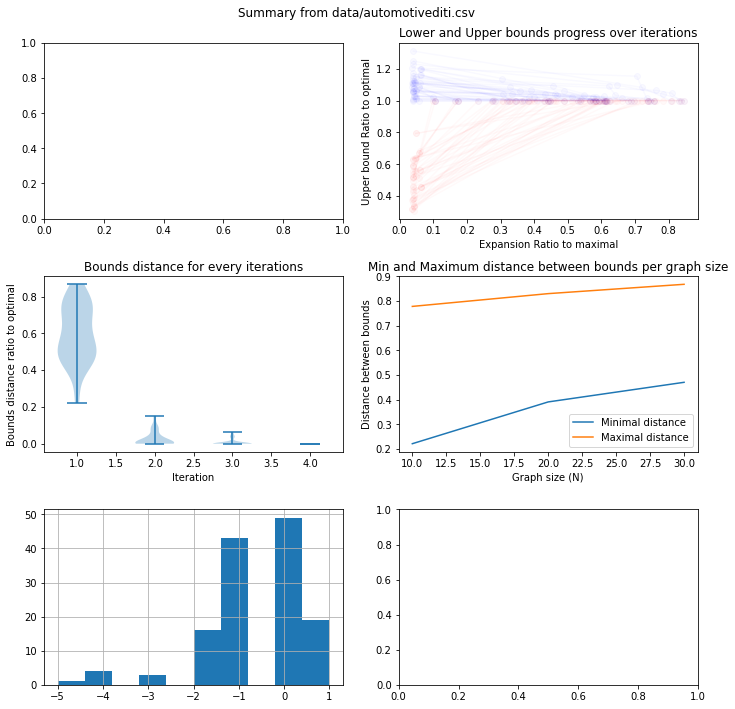

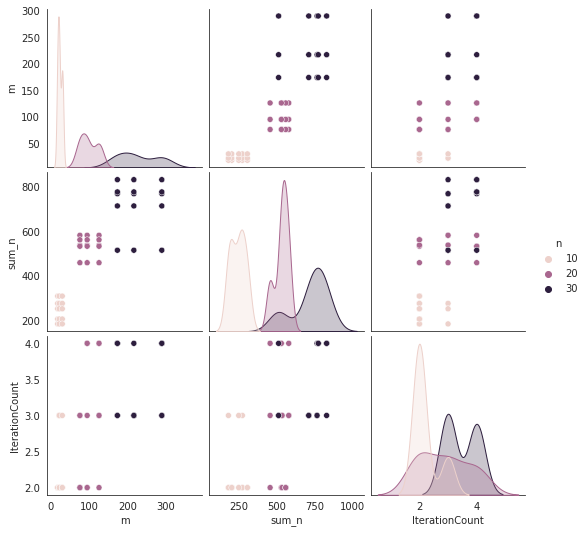

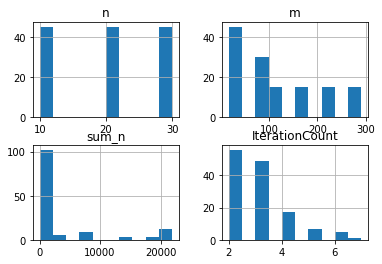

In [18]:
plotDataFile("data/automotivediti.csv")

# Drawing User cases

In [19]:
!mkdir figures -p
!rm -f figures/*

In [20]:
class Instance :
    def __init__ (self, n,m,seed,kind, DiEqTi) :
        self.n   = n
        self.m   = m
        self.kind   = kind
        self.seed   = seed
        self.DiEqTi = DiEqTi
        
    def __str__ (self) :
        return f"Instance ({self.n}, {self.m}, {self.seed}, {self.kind}, {self.DiEqTi})"
    def __repr__ (self) :
        return self.__str__()

def getLET(inst): 
    import os 
    import subprocess
    import sys
    from IPython import display
    valid_kinds = ALL_KIND
    n  = inst.n
    m = inst.m
    seed = inst.seed
    kind = inst.kind
    DiEqTi = inst.DiEqTi
    
    if kind == 1 : kind = "generic"
    if not kind in valid_kinds :
        print (f"invalid kind '{kind}'")
    assert( kind in valid_kinds )
        
    cmd = [ANALYSE, "-n", str(n), "-m", str(m), "-seed", str(seed), "-kind", kind, "-outputsvg"]
    if DiEqTi :
        cmd .append("-DiEqualTi")
    sys.stderr.write(f" " + " ".join(cmd))
    
    proc = subprocess.Popen([str(x) for x in cmd], stdout=subprocess.PIPE)
    out,err = proc.communicate()
    return display.SVG(out)

def getPEG(inst, upper=None, lower=None): 
    import os 
    import subprocess
    import sys
    from IPython import display
    assert (upper == None or lower==None) # Need only on of them
    
    n  = inst.n
    m = inst.m
    seed = inst.seed
    kind = inst.kind
    DiEqTi = inst.DiEqTi
    
    if kind == 1 : kind = "generic"
        
    if (upper) : peg_k = " ".join([str(x) for x in upper])    
    if (lower) : peg_k = " ".join([str(x) for x in lower])   
        
    cmd = [ANALYSE, "-n", str(n), "-m", str(m), "-seed", str(seed), "-kind", kind, 
           "-outputsvg", "-peg", peg_k]
    if DiEqTi :
        cmd .append("-DiEqualTi")
    sys.stderr.write(f" " + " ".join(cmd))
    proc = subprocess.Popen([str(x) for x in cmd], stdout=subprocess.PIPE)
    out,err = proc.communicate()
    required = ""
    res = ""
    if upper :
        required = f"// Upper bound with K=[{','.join([str(x) for x in upper])}]"
    if lower :
        required = f"// Lower bound with K=[{','.join([str(x) for x in lower])}]"
    print (f"<!-- {required} -->")
    for line in out.decode("utf-8").split("\n"):
        if line[:2] == "//":
            current = line
            if required == "" :
                print (line)
        elif current == required :
            res += (line)
    return display.SVG(res)

def saveSVGIntoPNG(obj, filename):
    from cairosvg import svg2png
    svg2png(bytestring=obj.data,write_to=filename)
        
def saveInto(obj, filename):
    with open(filename, 'w') as fdesc:
        fdesc.write(obj)
        

# Use-case 1: When Lower bound reach optimality first

This example shows a situation where lower bound can help to interupt computation earlier.

In [21]:
containsAnomalies_df = openLog("data/containsAnomalies.csv")

In [22]:
filtered_df = containsAnomalies_df.copy()

# small instances
filtered_df = filtered_df[filtered_df["sum_n"] < 50]
filtered_df = filtered_df[filtered_df["n"] == 4]
filtered_df = filtered_df[filtered_df["m"] == 3]

# Lower bound find it first.
filtered_df = filtered_df[filtered_df.apply(lambda x : x.LowerBounds.count(1.0) >= 1,axis=1)]
filtered_df = filtered_df[filtered_df.apply(lambda x : x.LowerBounds.index(1.0) < x.UpperBounds.index(1.0),axis=1)]

# Output instances
filtered_df[["seed","n", "m", "sum_n", "LowerBounds", "UpperBounds"]]

,seed,n,m,sum_n,LowerBounds,UpperBounds
10129,256,4,3,47,"[1.0, 1.0]","[1.5333333333333334, 1.0]"
10598,725,4,3,17,"[1.0, 1.0]","[1.3571428571428572, 1.0]"
10636,763,4,3,20,"[1.0, 1.0]","[1.2, 1.0]"
11660,1787,4,3,17,"[1.0, 1.0]","[1.263157894736842, 1.0]"
14228,4355,4,3,7,"[1.0, 1.0]","[1.375, 1.0]"
14308,4435,4,3,33,"[1.0, 1.0]","[1.3157894736842106, 1.0]"
15069,5196,4,3,29,"[1.0, 1.0]","[1.0909090909090908, 1.0]"
15162,5289,4,3,9,"[1.0, 1.0]","[1.3076923076923077, 1.0]"
15360,5487,4,3,26,"[1.0, 1.0]","[1.0714285714285714, 1.0]"
15589,5716,4,3,21,"[1.0, 1.0]","[1.5333333333333334, 1.0]"


In [23]:
%%script env ANALYSE="$ANALYSE" bash
$ANALYSE -n 4 -m 3 -seed 611 -kind generic  -agelatency

// Upper bound Longest path = 20
// Upper bound with K=[1,1,1,1]
// Lower bound Longest path = 12
// Lower bound with K=[1,1,1,1]
// Upper bound Longest path = 20
// Upper bound with K=[8,1,9,1]
// Lower bound Longest path = 20
// Lower bound with K=[8,1,9,1]
// Upper bound Longest path = 20
// Upper bound with K=[8,8,9,1]
// Lower bound Longest path = 20
// Lower bound with K=[8,8,9,1]
// Age Latency:20


 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg

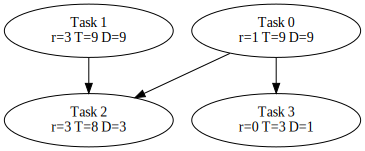

In [24]:
uc1 = Instance(4,3,611,"generic", False)
g = getLET(uc1)
saveSVGIntoPNG(g, "figures/usecase1.png")
g

This is a very simple example with 4 tasks and 3 edges. 
The very first partial expansion is using K=1,1,1,1:

<!-- // Upper bound with K=[1,1,1,1] -->


 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -peg 1 1 1 1

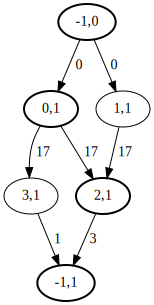

In [25]:
g = getPEG(uc1, upper=[1,1,1,1])
saveSVGIntoPNG(g, "figures/uc1_u1111.png")
g

<!-- // Lower bound with K=[1,1,1,1] -->


 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -peg 1 1 1 1

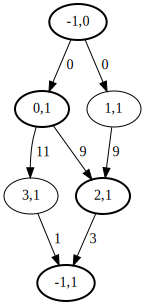

In [26]:
g = getPEG(uc1, lower=[1,1,1,1])
saveSVGIntoPNG(g, "figures/uc1_l1111.png")
g

Uppuer bound for the Age Latency is 20, meanwhile the lower bound is 12.
From there we naturally increase the values of K = 1,8,9,1. 

 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -peg 1 8 9 1

<!-- // Upper bound with K=[1,8,9,1] -->


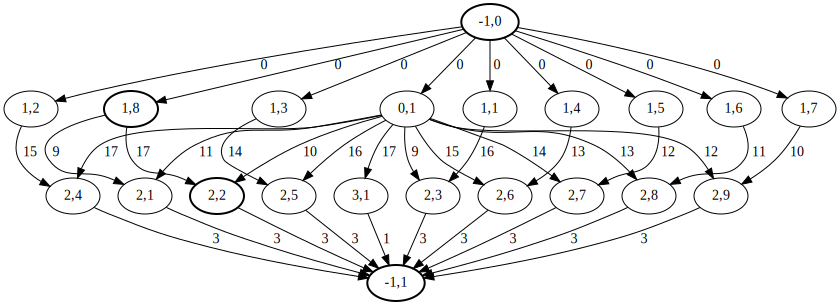

In [27]:
g = getPEG(uc1, upper=[1,8,9,1])
saveSVGIntoPNG(g, "figures/uc1_u1891.png")
g

 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 611 -kind generic -outputsvg -peg 1 8 9 1

<!-- // Lower bound with K=[1,8,9,1] -->


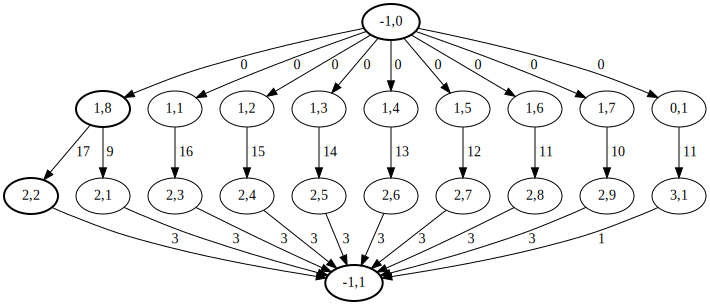

In [28]:
g = getPEG(uc1, lower=[1,8,9,1])
saveSVGIntoPNG(g, "figures/uc1_l1891.png")
g

Once again the upper bounds reach 20 for the age latency. Interestingly, this time the lower bound is also of 20. This garantie we reached optimality the algotihm terminates.

On the contrary, if we did not use the lower bound, we would require to interate another time in order to confirm this result with K=[8,8,9,1]. And only then we could have confirmed we reach optimality. 

# Use-case 2: When lower bound does not reach optimality

It is very interesting to note the existence of instances where, considering Algoritm 1, the lower bound will not be able to reach optimality. 
These very rare cases are possible, and force us to verify the original condition from Ning in addition of comparing lower and upper bound. 

The following example is one of these cases.

In [29]:
filtered_df = containsAnomalies_df.copy()
#filtered_df = filtered_df[filtered_df["IterationCount"] >=  3]
filtered_df = filtered_df[filtered_df["sum_n"] < 40]
filtered_df = filtered_df[filtered_df["n"] >= 3]
filtered_df = filtered_df[filtered_df["m"] >= 3]
filtered_df = filtered_df[filtered_df.apply(lambda x : x.LowerBounds[-1] != 1,axis=1)]
filtered_df = filtered_df[filtered_df.apply(lambda x : x.LowerBounds.count(1.0) == 0,axis=1)]

filtered_df[["seed","n", "m", "sum_n", "LowerBounds", "UpperBounds"]]

,seed,n,m,sum_n,LowerBounds,UpperBounds
28492,8619,4,4,22,"[0.6875, 0.9375]","[1.125, 1.0]"


In [30]:
%%script env ANALYSE="$ANALYSE" bash
$ANALYSE  -n 4 -m 3 -seed 3493 -kind generic -agelatency

// Upper bound Longest path = 15
// Upper bound with K=[1,1,1,1]
// Lower bound Longest path = 10
// Lower bound with K=[1,1,1,1]
// Upper bound Longest path = 15
// Upper bound with K=[1,1,1,2]
// Lower bound Longest path = 15
// Lower bound with K=[1,1,1,2]
// Upper bound Longest path = 15
// Upper bound with K=[1,4,5,4]
// Lower bound Longest path = 11
// Lower bound with K=[1,4,5,4]
// Age Latency:15


 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg

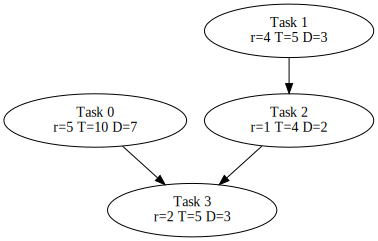

In [31]:
uc2 = Instance(4,3, 3493, "generic", False)
g = getLET(uc2)
saveSVGIntoPNG(g, "figures/usecase2.png")
g

First iteration, we identify a critical path, and update K accordingly.
Second iteration, we found a new path, however updating K does not chage its values. We reach the optimum. meanwhile, with the same exact value of K, the lower bound does not reach the optimum. 

<!-- // Upper bound with K=[1,1,1,1] -->


 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg -peg 1 1 1 1

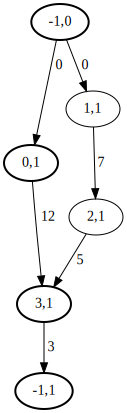

In [32]:
g = getPEG(uc2, upper=[1,1,1,1])
saveSVGIntoPNG(g, "figures/uc2_u1111.png")
g

<!-- // Upper bound with K=[1,4,5,4] -->


 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg -peg 1 4 5 4

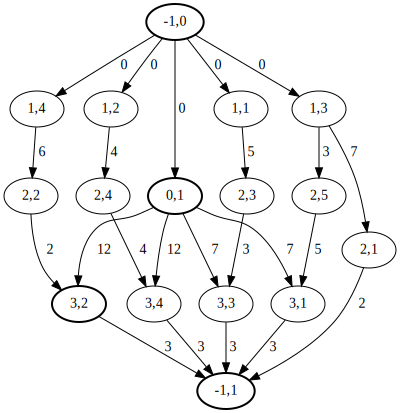

In [33]:
g = getPEG(uc2, upper=[1,4,5,4])
saveSVGIntoPNG(g, "figures/uc2_u1454.png")
g

 ../cmake-build-release/src//lig-analyse -n 4 -m 3 -seed 3493 -kind generic -outputsvg -peg 1 4 5 4

<!-- // Lower bound with K=[1,4,5,4] -->


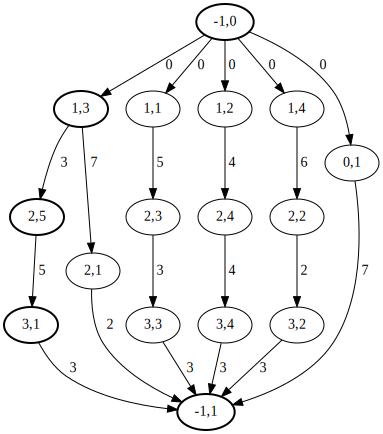

In [34]:
g = getPEG(uc2, lower=[1,4,5,4])
saveSVGIntoPNG(g, "figures/uc2_l1454.png")
g

# User-case 3: When lower bound decrease while K increase. 

Since Bodin2016, it is accepted that increasing the values of K arbitrarily does not necessarily improve estiation results.
However a dominant subset has been identified and consistantly improve the upper bound. 
Meanwhile we found example where an update of K can degrade the lower bound despite improving the upper bound.

In this example, the upper bound ciritical path for K=1,1,1,1 indicate a new vector K=[8,3,24,1,3]. This new vector K reach optimality.
However, the same update of K for the lower bound has the oposite effect that while lower bound was 19 initially, it went down to 12 after this update of K.



In [35]:
filtered_df = containsAnomalies_df.copy()
filtered_df = filtered_df[filtered_df["IterationCount"] >=  3]
filtered_df = filtered_df[filtered_df["sum_n"] < 60]
filtered_df = filtered_df[filtered_df["n"] >= 4]
filtered_df = filtered_df[filtered_df["m"] >= 4]
filtered_df = filtered_df[filtered_df.apply(lambda x : x.LowerBounds[1] > x.LowerBounds[2],axis=1)]

filtered_df[["seed","n", "m", "sum_n", "LowerBounds", "UpperBounds"]]

,seed,n,m,sum_n,LowerBounds,UpperBounds
20425,552,4,4,21,"[0.6923076923076923, 1.0, 0.46153846153846156]","[1.0, 1.0, 1.0]"
23366,3493,4,4,15,"[0.6666666666666666, 1.0, 0.7333333333333333]","[1.0, 1.0, 1.0]"
23899,4026,4,4,19,"[0.7142857142857143, 1.0, 0.5714285714285714]","[1.0, 1.0, 1.0]"
25223,5350,4,4,53,"[0.6842105263157895, 1.0, 0.6842105263157895]","[1.0, 1.0, 1.0]"
26207,6334,4,4,57,"[0.6, 1.0, 0.5]","[1.0, 1.0, 1.0]"
26265,6392,4,4,27,"[0.5555555555555556, 1.0, 0.6666666666666666]","[1.1111111111111112, 1.0, 1.0]"
26800,6927,4,4,58,"[0.7222222222222222, 1.0, 0.5555555555555556]","[1.0, 1.0, 1.0]"
28950,9077,4,4,53,"[0.4, 1.0, 0.9333333333333333]","[1.2666666666666666, 1.1333333333333333, 1.0]"
31302,1430,5,4,43,"[0.38461538461538464, 1.0, 0.8461538461538461]","[1.0, 1.0, 1.0]"
35349,5477,5,4,39,"[0.5, 1.0, 0.5]","[1.0, 1.0, 1.0]"


 ../cmake-build-release/src//lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg

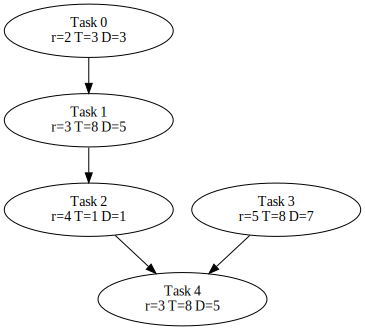

In [36]:
uc3 = Instance(5,4,2070,"generic", False)
uc3_start_k = [1,1,1,1,1]
uc3_end_k = [8,3,24,1,3]

g = getLET(uc3)
saveSVGIntoPNG(g, "figures/usecase3.png")
g

 ../cmake-build-release/src//lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg -peg 1 1 1 1 1

<!-- // Upper bound with K=[1,1,1,1,1] -->


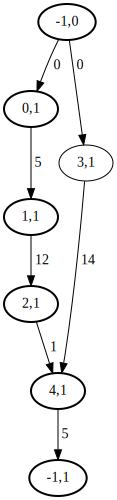

In [37]:
g = getPEG(uc3, upper = uc3_start_k)
saveSVGIntoPNG(g, "figures/uc3_u11111.png")
g

<!-- // Lower bound with K=[1,1,1,1,1] -->


 ../cmake-build-release/src//lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg -peg 1 1 1 1 1

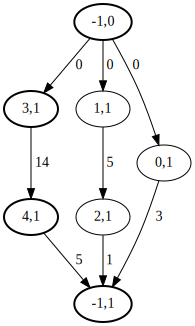

In [38]:
g = getPEG(uc3, lower = uc3_start_k)
saveSVGIntoPNG(g, "figures/uc3_l11111.png")
g

 ../cmake-build-release/src//lig-analyse -n 5 -m 4 -seed 2070 -kind generic -outputsvg -peg 8 3 24 1 3

<!-- // Lower bound with K=[8,3,24,1,3] -->


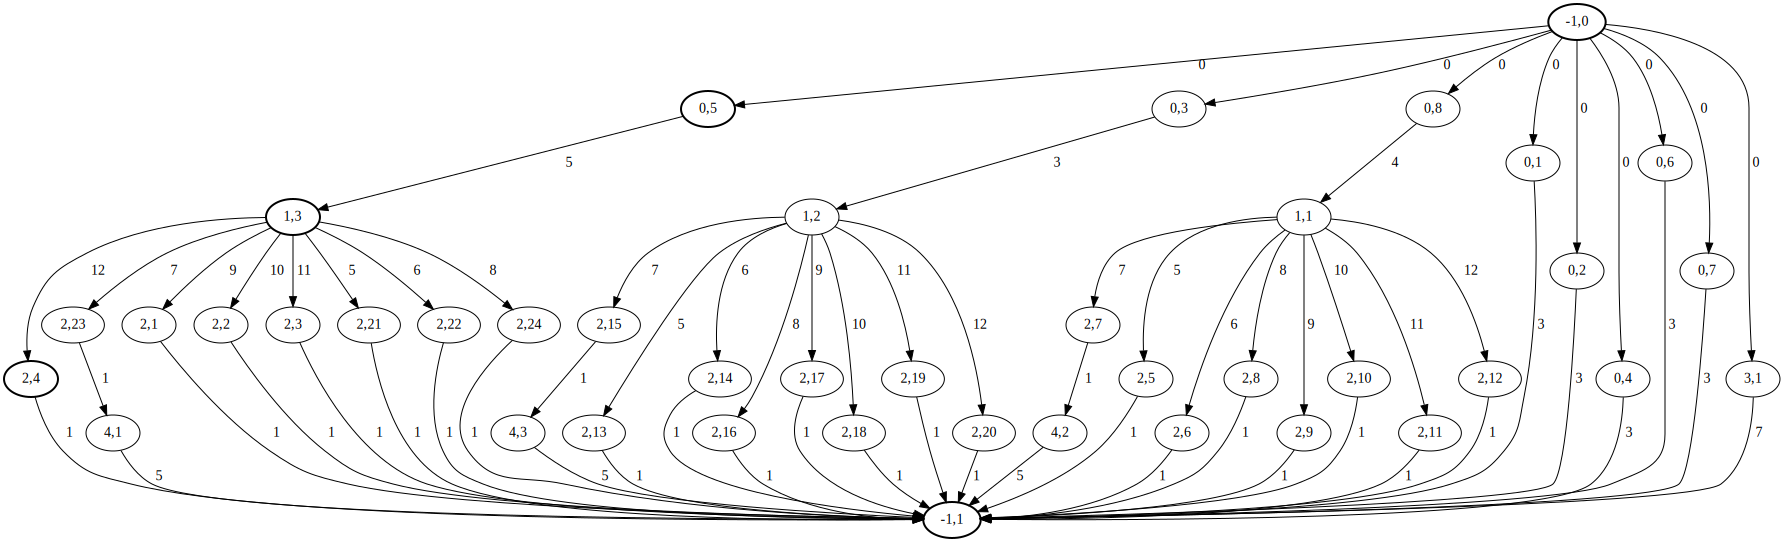

In [39]:
g = getPEG(uc3, lower=uc3_end_k)
saveSVGIntoPNG(g, "figures/uc3_l832413.png")
g

# Looking for example

In [40]:
fdf = openLogs([ "data/automotivediti.csv","data/harmonic.csv","data/harmonicditi.csv", "data/containsAnomalies.csv", "data/generic.csv", "data/containsAnomalies_diti.csv"])

In [41]:
demo = fdf
demo = demo[demo["IterationCount"] == 3]
demo = demo[demo["n"] == 4]
demo = demo[demo["bounds_shift"] == -1]
demo = demo[demo.apply(lambda x : x["ExpansionVertex"][-1] != 1, axis = 1)]
demo = demo[demo.apply(lambda x : x["BoundsDistances"][-1] == 0, axis = 1)]
demo = demo[demo.apply(lambda x : x["BoundsDistances"][-2] != 0, axis = 1)]
demo = demo.sort_values(["sum_n"])
demo

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,...,total_time,filename,edge_density,gen_time_detail,lbp_time_detail,ubp_time_detail,BoundsDistances,bounds_shift,early_bounds,remain_time
85883,25703,5830,generic,1,4,4,19,28,3,"[0.2857142857142857, 0.5714285714285714, 0.761...",...,0.0,data/containsAnomalies_diti.csv,1.High,"[0.0, 0.02, 0.01]","[0.0, 0.0, 0.01]","[0.0, 0.01, 0.01]","[0.7500000000000001, 0.0714285714285714, 0.0]",-1.0,False,-0.06
29668,29533,9660,generic,0,4,4,31,16,3,"[0.18181818181818182, 0.5757575757575758, 0.69...",...,0.0,data/containsAnomalies.csv,1.High,"[0.0, 0.03, 0.02]","[0.0, 0.01, 0.01]","[0.0, 0.01, 0.01]","[0.875, 0.0625, 0.0]",-1.0,False,-0.09
29399,29264,9391,generic,0,4,4,43,21,3,"[0.13333333333333333, 0.6222222222222222, 0.8]",...,0.0,data/containsAnomalies.csv,1.High,"[0.01, 0.03, 0.04]","[0.0, 0.01, 0.02]","[0.0, 0.03, 0.02]","[0.7142857142857142, 0.09523809523809534, 0.0]",-1.0,False,-0.16


In [42]:
instances = demo.apply(lambda x : Instance(x.n,x.m,x.seed,x.kind, x.DiEqTi), axis = 1).tolist()
instances

[Instance (4, 4, 5830, generic, 1),
 Instance (4, 4, 9660, generic, 0),
 Instance (4, 4, 9391, generic, 0)]

 ../cmake-build-release/src//lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputsvg

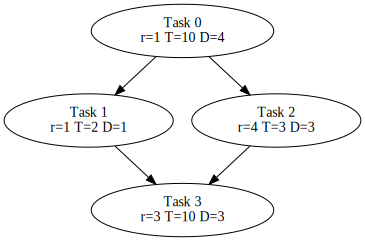

In [43]:
 getLET(instances[1])

In [44]:
example = Instance (4, 4, 9660, 1, 0)

 ../cmake-build-release/src//lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputsvg

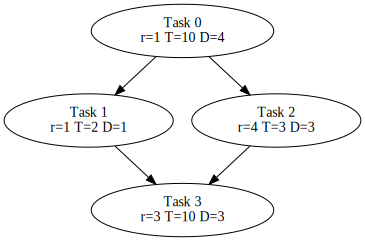

In [45]:
g = getLET(example)
saveSVGIntoPNG(g, "figures/example.png")
g

<!-- // Upper bound with K=[1,1,1,1] -->


 ../cmake-build-release/src//lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputsvg -peg 1 1 1 1

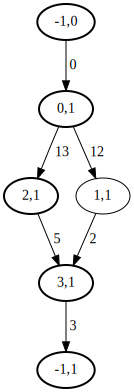

In [46]:
g = getPEG(example, upper=[1,1,1,1])
saveSVGIntoPNG(g, "figures/example_u1111.png")
g

In [47]:
def getSchedule(inst, duration): 
    import os 
    import subprocess
    import sys
    from IPython import display
    n  = inst.n
    m = inst.m
    seed = inst.seed
    kind = inst.kind
    DiEqTi = inst.DiEqTi
    
    if kind == 1 : kind = "generic"
    cmd = [ANALYSE, "-n", str(n), "-m", str(m), "-seed", str(seed), "-kind", kind, "-outputtikz","-schedule_duration", str(duration)]
    if DiEqTi :
        cmd .append("-DiEqualTi")
    sys.stderr.write(f" " + " ".join(cmd))
    
    proc = subprocess.Popen([str(x) for x in cmd], stdout=subprocess.PIPE)
    out,err = proc.communicate()
    return out.decode("utf-8")

In [48]:
schedule = getSchedule(example, 150)
print(schedule)
saveInto(schedule,"figures/example_schedule.tikz")


\begin{tikzpicture}[transform shape,scale=0.5]
\LETSchedule{4}{150}
\LETTask{0}{1}{4}{4}{10}
\LETTask{1}{1}{1}{1}{2}
\LETTask{2}{4}{3}{3}{3}
\LETTask{3}{3}{3}{3}{10}
\LETExecutionDependency{1}{1}{3}{1}
\LETExecutionDependency{1}{6}{3}{2}
\LETExecutionDependency{1}{11}{3}{3}
\LETExecutionDependency{1}{16}{3}{4}
\LETExecutionDependency{1}{21}{3}{5}
\LETExecutionDependency{1}{26}{3}{6}
\LETExecutionDependency{1}{31}{3}{7}
\LETExecutionDependency{1}{36}{3}{8}
\LETExecutionDependency{1}{41}{3}{9}
\LETExecutionDependency{1}{46}{3}{10}
\LETExecutionDependency{1}{51}{3}{11}
\LETExecutionDependency{1}{56}{3}{12}
\LETExecutionDependency{1}{61}{3}{13}
\LETExecutionDependency{1}{66}{3}{14}
\LETExecutionDependency{0}{1}{1}{3}
\LETExecutionDependency{0}{1}{1}{4}
\LETExecutionDependency{0}{1}{1}{5}
\LETExecutionDependency{0}{1}{1}{6}
\LETExecutionDependency{0}{1}{1}{7}
\LETExecutionDependency{0}{2}{1}{8}
\LETExecutionDependency{0}{2}{1}{9}
\LETExecutionDependency{0}{2}{1}{10}
\LETExecutionDependency

 ../cmake-build-release/src//lig-analyse -n 4 -m 4 -seed 9660 -kind generic -outputtikz -schedule_duration 150

# Generate DataSet analysis

In [49]:
%%script env BENCHMARK="$BENCHMARK" bash

for kind in automotive harmonic generic ; do 
    if [ ! -e data/$kind.dataset.csv ]; then 
        $BENCHMARK -kind $kind -begin_n 1 -end_n 500  -step_n 1 -sample_count 1 -iter_count 3 -dryrun -detailed -logfile data/$kind.dataset.csv;
    fi
done


In [50]:
dataset_df = openLogs(["./data/automotive.dataset.csv", "./data/harmonic.dataset.csv", "./data/generic.dataset.csv"])

In [51]:
dataset_df = dataset_df[["kind","edge_density", "n", "m", "sum_n"]]

In [52]:
dataset_df.groupby(["n", "kind"]).mean().transpose()

n            1                           2                            3    \
kind  automotive generic harmonic automotive generic harmonic  automotive   
m            0.0     0.0      0.0        0.0     0.0      0.0    1.333333   
sum_n        1.0     1.0      1.0        3.0    19.0     13.0  121.000000   

n                                  4    ...           497           498  \
kind     generic   harmonic automotive  ...      harmonic    automotive   
m       1.333333   1.333333        3.0  ...  64366.666667  64626.333333   
sum_n  28.000000  13.000000       43.0  ...   6354.000000  12229.000000   

n                                            499                               \
kind         generic      harmonic    automotive        generic      harmonic   
m       64626.333333  64626.333333  64886.333333   64886.333333  64886.333333   
sum_n  341572.000000  19343.000000  13609.000000  376051.000000  16358.000000   

n            500                     
kind  automotive   generic harmonic  
m        65147.0   65147.0  65147.0  
sum_n    12629.0  362248.0  30930.0  

[2 rows x 1500 columns]

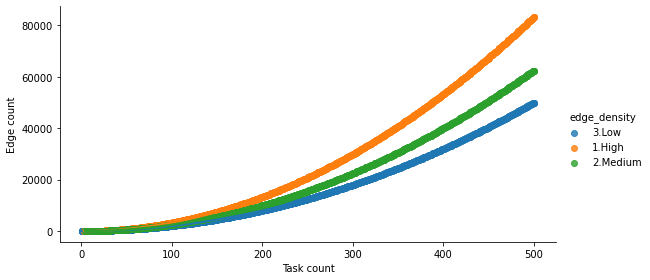

In [53]:
g = sns.lmplot(x="n", y="m", hue="edge_density", data=dataset_df, legend=True, height=4, aspect= 2, order=3)
g = g.set_axis_labels("Task count", "Edge count")
plt.savefig("figures/dataset_size.pdf", bbox_inches='tight')

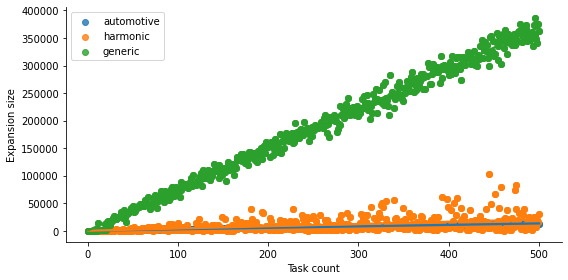

In [54]:
g = sns.lmplot(x="n", y="sum_n", hue="kind", data=dataset_df, legend=False, height=4, aspect= 2)
g = g.set_axis_labels("Task count", "Expansion size")
_ = g.ax.legend(loc=2)
plt.savefig("figures/dataset_complexity.pdf", bbox_inches='tight')

# Generating timing analysis

In [74]:
df.columns

Index(['index', 'seed', 'kind', 'DiEqTi', 'n', 'm', 'sum_n', 'AgeLatency',
       'IterationCount', 'ExpansionVertex', 'ExpansionEdges', 'LowerBounds',
       'UpperBounds', 'gen_time', 'lbp_time', 'ubp_time', 'total_time',
       'filename', 'edge_density', 'gen_time_detail', 'lbp_time_detail',
       'ubp_time_detail', 'BoundsDistances', 'bounds_shift', 'early_bounds',
       'remain_time', 'NRange'],
      dtype='object')

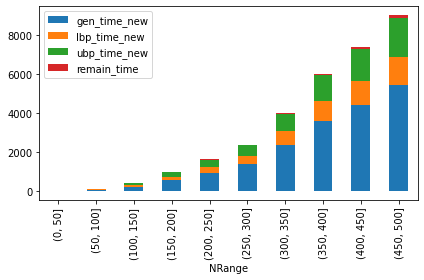

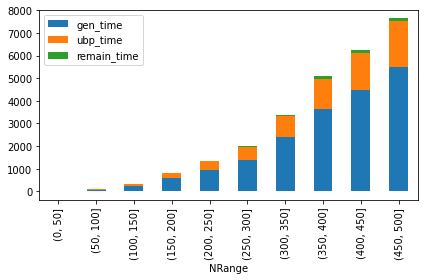

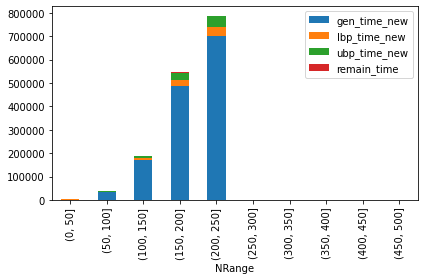

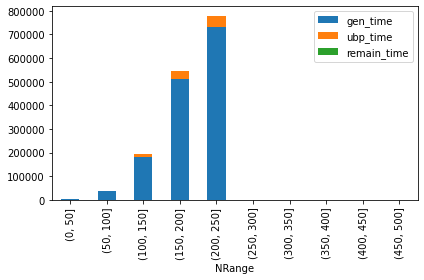

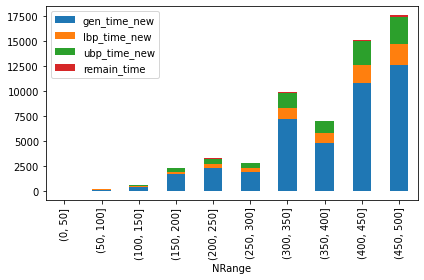

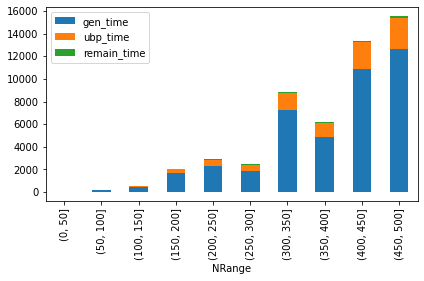

In [170]:
for kind in ALL_KIND:
    df = openLogs([f"../{kind}.paper.csv"], with_gain=np.arange(0,1,1))
    df['NRange'] = pd.cut(df['n'], range(0,501,50))
    df_mean = df.groupby("NRange").mean()
    df_mean.plot(kind='bar',y=["gen_time_new", "lbp_time_new", "ubp_time_new", 'remain_time'], stacked=True)
    plt.tight_layout()
    plt.savefig(f"figures/new_timings_{kind}.pdf", bbox_inches='tight')
    
    df_mean.plot(kind='bar',y=["gen_time", "ubp_time", 'remain_time'], stacked=True)
    plt.tight_layout()
    plt.savefig(f"figures/old_timings_{kind}.pdf", bbox_inches='tight')

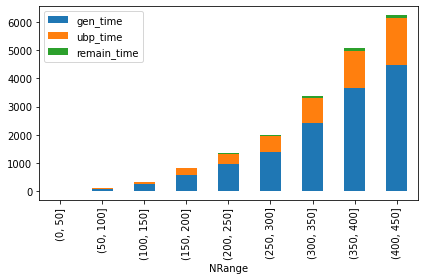

In [84]:
df = openLogs(["../automotive.paper.csv"])
df['NRange'] = pd.cut(df['n'], range(0,500,50))
df_mean = df.groupby("NRange").mean()
df_mean.plot(kind='bar',y=["gen_time", "ubp_time", 'remain_time'], stacked=True)
plt.tight_layout()
plt.savefig("figures/old_timings_automotive.pdf", bbox_inches='tight')

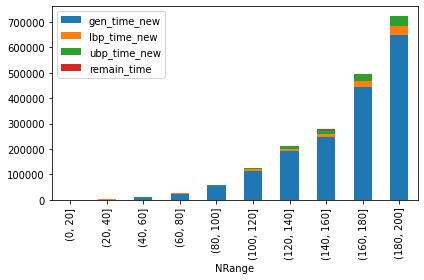

In [85]:
df = openLogs(["../generic.paper.csv"], with_gain=np.arange(0,1,1))
df['NRange'] = pd.cut(df['n'], range(0,201,20))
df_mean = df.groupby("NRange").mean()
df_mean.plot(kind='bar',y=["gen_time_new", "lbp_time_new", "ubp_time_new", 'remain_time'], stacked=True)
plt.tight_layout()
plt.savefig("figures/new_timings_generic.pdf", bbox_inches='tight')

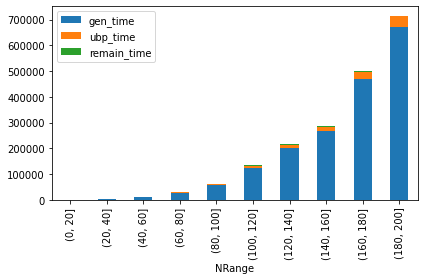

In [87]:
df = openLogs(["../generic.paper.csv"])
df['NRange'] = pd.cut(df['n'], range(0,201,20))
df_mean = df.groupby("NRange").mean()
df_mean.plot(kind='bar',y=["gen_time", "ubp_time", 'remain_time'], stacked=True)
plt.tight_layout()
plt.savefig("figures/old_timings_generic.pdf", bbox_inches='tight')

# Generate Improvement analysis

## Execution time analysis

In [57]:
df = openLogs(["../automotive.paper.csv", "../harmonic.paper.csv", "../generic.paper.csv"], with_gain=np.arange(0,151,5))

In [58]:
df.columns

Index(['index', 'seed', 'kind', 'DiEqTi', 'n', 'm', 'sum_n', 'AgeLatency',
       'IterationCount', 'ExpansionVertex',
       ...
       'space_gain135', 'NewIterationCount140', 'time_gain140',
       'space_gain140', 'NewIterationCount145', 'time_gain145',
       'space_gain145', 'NewIterationCount150', 'time_gain150',
       'space_gain150'],
      dtype='object', length=121)

In [59]:
## This is so brutal, I should find how to do this properly !!! 

tmp = df.groupby(["kind","edge_density","n"]).min()[[x for x in df.columns if "time_gain" in x]].reset_index()

res = None
for gainVal in np.arange(0,151,5) :
    start = tmp[["kind","edge_density","n"]].copy()
    start["Accepted error"] = gainVal
    start["Computational gain"] = tmp["time_gain" + str(gainVal)] * 100
    start
    res = pd.concat([res,start], ignore_index=True)
res

,kind,edge_density,n,Accepted error,Computational gain
0,automotive,1.High,3,0,-33.333333
1,automotive,1.High,4,0,-25.000000
2,automotive,1.High,6,0,-30.508475
3,automotive,1.High,7,0,-32.258065
4,automotive,1.High,8,0,-23.809524
...,...,...,...,...,...
111626,harmonic,3.Low,496,150,99.592051
111627,harmonic,3.Low,497,150,97.855442
111628,harmonic,3.Low,498,150,99.490387
111629,harmonic,3.Low,499,150,99.520427


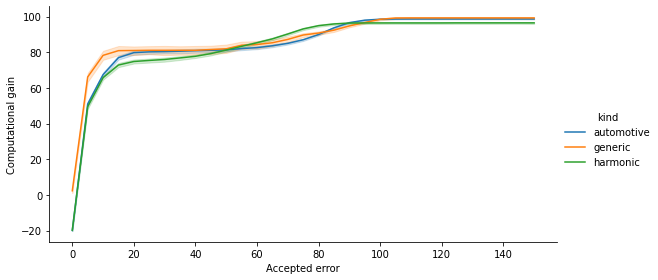

In [60]:
sns.relplot(x="Accepted error",y=  "Computational gain",kind="line",  hue="kind" ,  data=res, legend=True, height=4, aspect= 2)

plt.savefig("figures/computational_gain.pdf", bbox_inches='tight')

## What is the time spent on the first iteration over N compared to the time spent on the total?

## Space analysis

In [61]:
## This is so brutal, I should find how to do this properly !!! 

tmp = df.groupby(["kind","edge_density"]).mean()[[x for x in df.columns if "space_gain" in x]].reset_index()

res = None
for gainVal in np.arange(0,151,5) :
    start = tmp[["kind","edge_density"]].copy()
    start["Accepted error"] = gainVal
    start["Spacial gain"] = tmp["space_gain" + str(gainVal)] * 100
    start
    res = pd.concat([res,start], ignore_index=True)
res 

,kind,edge_density,Accepted error,Spacial gain
0,automotive,1.High,0,0.050363
1,automotive,2.Medium,0,0.025082
2,automotive,3.Low,0,0.096271
3,generic,1.High,0,1.110557
4,generic,2.Medium,0,1.337090
...,...,...,...,...
274,generic,2.Medium,150,99.020145
275,generic,3.Low,150,95.633211
276,harmonic,1.High,150,90.102099
277,harmonic,2.Medium,150,88.461871


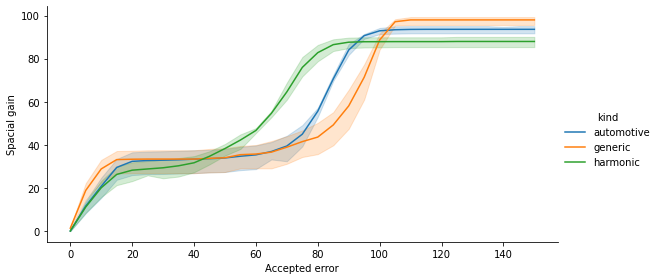

In [62]:
sns.relplot(x="Accepted error",y=  "Spacial gain",kind="line",  hue="kind" ,  data=res, legend=True, height=4, aspect= 2)

plt.savefig("figures/spacial_gain.pdf", bbox_inches='tight')

(0.0, 2.0)

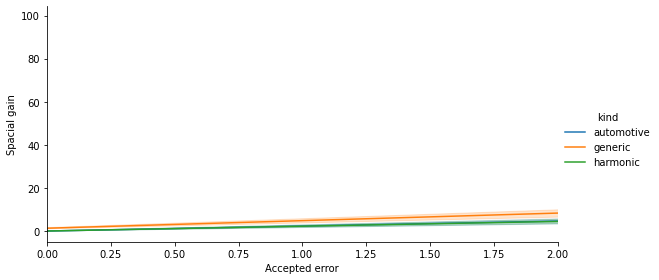

In [63]:
sns.relplot(x="Accepted error",y=  "Spacial gain",kind="line",  hue="kind" ,  data=res, legend=True, height=4, aspect= 2)

plt.xlim(0, 2)

# Bound analysis

In [64]:
df = openLogs(["../automotive.paper.csv", "../harmonic.paper.csv", "../generic.paper.csv"])

In [65]:
def plotBounds(df, title = None) :
    sdf = df.copy()
    sdf.LowerBounds = sdf.LowerBounds.apply(lambda x: [max(x[:i]+[x[i]]) for i in range(len(x))])
    sdf.LowerBounds = sdf.apply (lambda x : x.LowerBounds + (df.IterationCount.max() - x.IterationCount)*x.LowerBounds[-1:], axis = 1)
    sdf.UpperBounds = sdf.apply (lambda x : x.UpperBounds + (df.IterationCount.max() - x.IterationCount)*x.UpperBounds[-1:], axis = 1)
    plt.figure()
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    if title is None :
        _ = plt.title("Lower and Upper bounds progress over iterations for all cases")
    else :
        _ = plt.title(title)
            

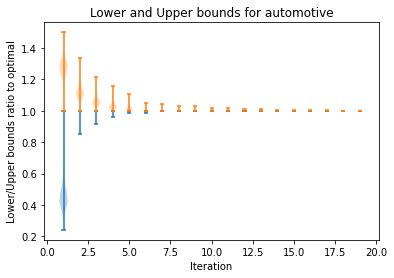

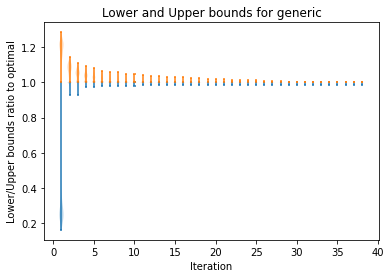

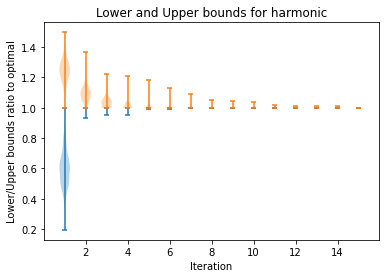

In [66]:
for kind in ALL_KIND:
    plotBounds(df[df["kind"] == kind], title = f"Lower and Upper bounds for {kind}") 
    plt.savefig(f"figures/bounds_{kind}.pdf", bbox_inches='tight')

# Iteration Count 

Edge density has no impact on edge density

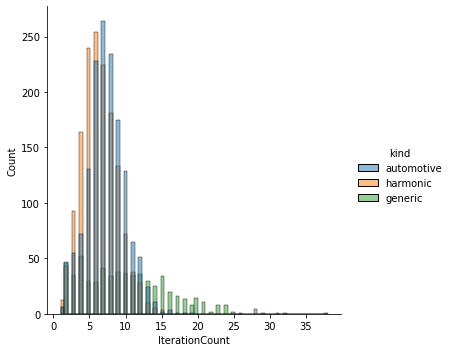

In [172]:
df = openLogs(["../automotive.paper.csv", "../harmonic.paper.csv", "../generic.paper.csv"])
sns.displot(df, x="IterationCount", hue="kind")
plt.savefig(f"figures/iterations_distribution.pdf", bbox_inches='tight')

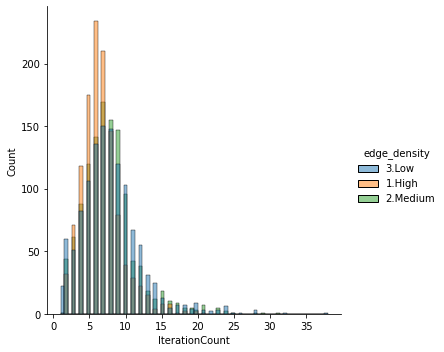

In [68]:
sns.displot(df, x="IterationCount", hue="edge_density")

# Iterations saved

In [88]:
df = openLogs(["../automotive.paper.csv", "../harmonic.paper.csv", "../generic.paper.csv"], with_gain=np.arange(0,151,5))
df["NewIterationCount0"]

0        1
1        1
2        1
3        1
4        1
        ..
3614    16
3615    20
3616    22
3617    12
3618    34
Name: NewIterationCount0, Length: 3619, dtype: int64

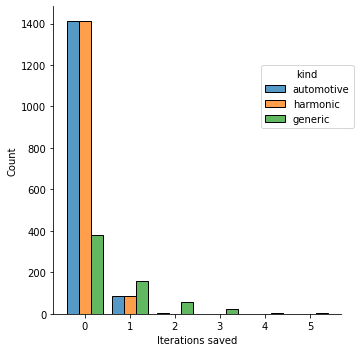

In [154]:
df["Iterations saved"] = (df["IterationCount"] - df["NewIterationCount0"])
df["Iterations saved"] = pd.Categorical(df["Iterations saved"],
                                   ordered=True)

g = sns.displot(x="Iterations saved",data=df, log_scale=(False,False), kde = False, shrink=.8, kind="hist", hue="kind", multiple="dodge")
sns.move_legend(obj = g, loc = 'upper right', bbox_to_anchor = (0.80, 0.82), frameon = True)
plt.savefig(f"figures/saved_iterations.pdf", bbox_inches='tight')